# Is the increase in your conversion rate due to chance?


## Introduction

For this project, our goal is to help an e-commerce company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision. The company has developed  new web page in order to try and increase the user conversion rate, meaning the proportion of users who decide to pay for the company's product. 

### Data validation

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('data/data_without_difference.csv')
df.head()

,user_id,group,convert
0,95,control,1
1,78,control,0
2,13,control,0
3,38,treatment,0
4,34,treatment,0


In [3]:
df.shape

(100, 3)

In [4]:
df['user_id'].nunique()

100

In [5]:
# The proportion of users converted
df['convert'].mean()

0.16

In [6]:
df['group'].value_counts()

treatment    50
control      50
Name: group, dtype: int64

- <font size=3>**Probability**<font size=3>

**The probability of an individual converting regardless of the page they receive**

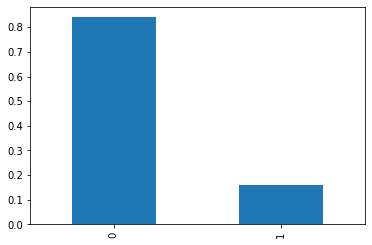

In [7]:
df['convert'].value_counts(normalize=True).plot.bar();

**The probability of an individual converting, given the group that they belong to:**

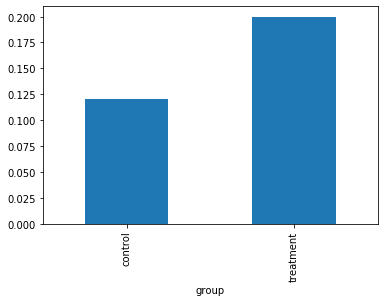

In [8]:
df.groupby('group')['convert'].mean().plot.bar();

**Compute the observed difference between conversion rates:**

In [9]:
df.groupby('group')['convert'].mean()[1] - df.groupby('group')['convert'].mean()[0]

0.08000000000000002

There is a increase of approximately 8 % in conversion rate upon the change to new page. 

**Check whether the traffic is comparable for both pages:**

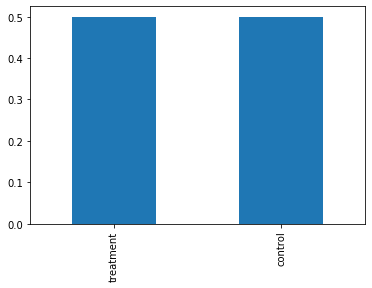

In [10]:
df['group'].value_counts(normalize=True).plot.bar();

The traffic for both pages are comparable, thus not likely to contribute to biases in the convertion rate.

**The conversion rate for the treatment group is higher than that for the treatment group. This seems to suggest that the new treatment page does not lead to more conversions.**<br>

**But we need to conduct hypothesis testing to evaluate whether the difference is statistically significant or due to chance.**

## Hypothesis testing

- <font size=3>**Setting up null and alternative hypothesis**<font size=3>

For now, consider we need to make the decision just based on all the data provided.  We will assume that the old page is better unless the new page proves to be definitely better at an error rate of 5%. The null and alternative hypotheses will be as follows:

- Null hypothesis: **$p_{new}$** - **$p_{old}$** <= 0
- Alternative hypothesis: **$p_{new}$** - **$p_{old}$** > 0

- <font size=3>**Simulating from the null hypothesis**<font size=3>

We first assume that the probability of converting is the same for both groups. This value would be set to the conversion rate of the whole sample, which is 0.16. This is to simulate the null hypothesis.<br>

What we need to do is to perform a sampling distribution for the difference in conversion rate between the two groups over 10,000 iterations. The sample size is our current sample size 50.<br>

In [11]:
p_new = df['convert'].mean()
p_old = p_new
print('p_new:', p_new, 'p_old:', p_old)

p_new: 0.16 p_old: 0.16


In [12]:
n_new = len(df[df['group'] == 'treatment'])
n_old = len(df[df['group'] == 'control'])
print('n_new:', n_new, 'n_old:', n_old)

n_new: 50 n_old: 50


Simulate 10,000 $p_{new}$ - $p_{old}$ values to understand how much our results may differ if we did the study again

In [13]:
all_diffs = []
for _ in range(10000):
    new_page_converted = np.random.choice([1, 0], size=n_new, p=[p_new, (1-p_new)])
    old_page_converted = np.random.choice([1, 0], size=n_old, p=[p_old, (1-p_old)])
    diff = new_page_converted.mean() - old_page_converted.mean()
    all_diffs.append(diff)
all_diffs = np.array(all_diffs)

- <font size=3>**Plot the null distribution**<font size=3>

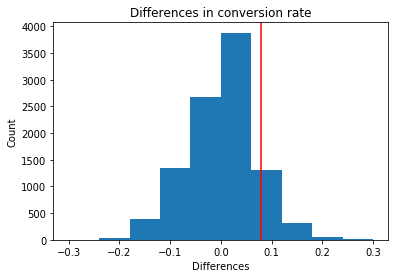

In [14]:
# Null distribution
plt.hist(all_diffs);
plt.xlabel('Differences')
plt.ylabel('Count')
plt.title('Differences in conversion rate')


# Plot observed difference in conversion rate
observed_diff = df[df['group'] == 'treatment']['convert'].mean() - df[df['group'] == 'control']['convert'].mean()
plt.axvline(observed_diff, c='red')

- <font size=3>**Compute p-value**<font size=3>
    
P-value: the proportion of the **p_diffs** that is greater than the actual difference observed in **ab_data.csv**

In [15]:
(all_diffs > observed_diff).sum() / len(all_diffs)

0.1062

Here, we computed the **p-value**, which is the probability of obtaining the statistic **as extreme as the test result**, if the **null hypothesis is true**.<br><br>
In the current case, the p-value is approximately 0.1, which suggests that if the old page is indeed better or the same as the new page, the probability of obtaining the observed difference in conversion rate is 10%. **This probability is higher than our threshold 5%, indicating that it is possible that the old page is better or the same as the new page.**

We can use Statsmodels library to achieve similar results

In [16]:
import statsmodels.api as sm
from scipy.stats import norm

convert_old = df[df['group'] == 'control']['convert'].sum()
convert_new = df[df['group'] == 'treatment']['convert'].sum()

In [17]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')

print(z_score, p_value)

-1.0910894511799623 0.13761676203741707


In [18]:
print(norm.cdf(z_score)) # significance of our z-score 

print(norm.ppf(1-(0.05))) # critical value at 95% confidence for one-tail test

0.13761676203741707
1.6448536269514722




**Since the z-score of 0.1376 is **less than the critical value** of 1.6448536269514722, we **fail to reject the null hypothesis** that the old page is better or the same as the new page.**<br><br>
**This is also consistent with the p-value computed from simulations.**

## Limitations of the approach

- We don't have information on whether the users in the test are existing or new users. Therefore, whether **change aversion and novelty effects** introduced any biases to the test results cannot be analysed.<br><br>

- Conversion rate may not be the **best metric** if the business objective is to increase revenue as the price of the product or customer lifetime value may also affect the revenue.<br><br>